In [30]:
from sage.all_cmdline import *   # import sage library

# from solid_angle_code.solid_angle_sage import *
from solid_angle_code.solid_angle_sage import solid_angle_general, solid_angle_2d, solid_angle_3d
import time
import numpy as np
import random

SEED = 2
SF = 1

seed = SEED
np.random.seed(SEED)
np.random.seed(seed)
random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.enabled = False

sf = SF 

OSError: did not find file '/mnt/shared/jaeyoung/cl_gym/solid_angle_code/logging.sage' to load or attach

In [ ]:
result1_20, result1_40, result1_80, result1_160, = list(), list(), list(), list(), 
size_list = [2, 3, 4, 8, 16, 32, 64, 128, 256, 512]
size_list = [4]
cone_list1 = []
for s in size_list:
    print(f"vector dim: {s}, number of vector: {s}")
    start = time.time()
    ray = np.round(np.random.normal(size=[s, s]), sf)*10**sf
    ray = np.asarray(ray, dtype=int)
    cone_list1.append(ray)
    print(f"{ray=}")
    A = matrix(ray)
    start = time.time()
    a = solid_angle_general(A, deg=20)
    print(f" ## solid angle(deg=20): {a}")
    result1_20.append(a)
    solid_angle_time = time.time()
    print(f"Time to measure solid angle : {round(solid_angle_time - start, 2)}")
    start = time.time()
    b = solid_angle_general(A, deg=40)
    print(f" ## solid angle(deg=40): {b}")
    result1_40.append(b)
    solid_angle_time = time.time()
    print(f"Time to measure solid angle : {round(solid_angle_time - start, 2)}")
    start = time.time()
    c = solid_angle_general(A, deg=80)
    print(f" ## solid angle(deg=80): {c}")
    result1_80.append(c)
    solid_angle_time = time.time()
    print(f"Time to measure solid angle : {round(solid_angle_time - start, 2)}")
    d = solid_angle_general(A, deg=160)
    print(f" ## solid angle(deg=160): {d}")
    result1_160.append(d)
    solid_angle_time = time.time()
    print(f"Time to measure solid angle : {round(solid_angle_time - start, 2)}")
    print()



vector dim: 4, number of vector: 4
ray=array([[ -4,  -1, -21,  16],
       [-18,  -8,   5, -12],
       [-11,  -9,   6,  23],
       [  0, -11,   5,  -6]])


 ## solid angle(deg=20): 0.04012700973195804
Time to measure solid angle : 4.34


 ## solid angle(deg=40): 0.04012700973195804
Time to measure solid angle : 4.11


 ## solid angle(deg=80): 0.04012700973195804
Time to measure solid angle : 4.11
 ## solid angle(deg=160): 0.04012700973195804
Time to measure solid angle : 8.19



In [ ]:
result2_20, result2_40, result2_80, result2_160, = list(), list(), list(), list(), 
size_list = [2, 3, 4, 8, 16, 32, 64, 128, 256, 512]
# size_list = [8]
cone_list1 = []
for s in size_list:
    print(f"vector dim: {s}, number of vector: {s}")
    start = time.time()
    ray = np.round(np.random.normal(size=[s, s]), sf)*10**sf
    ray = np.asarray(ray, dtype=int)
    cone_list1.append(ray)
    print(f"{ray=}")
    A = matrix(ray)
    start = time.time()
    a = solid_angle_general(A, deg=10)
    print(f" ## solid angle(deg=10): {a}")
    result2_20.append(a)
    solid_angle_time = time.time()
    print(f"Time to measure solid angle : {round(solid_angle_time - start, 2)}")
    # start = time.time()
    # b = solid_angle_general(A, deg=40)
    # print(f" ## solid angle(deg=40): {b}")
    # result2_40.append(b)
    # solid_angle_time = time.time()
    # print(f"Time to measure solid angle : {round(solid_angle_time - start, 2)}")
    # start = time.time()
    # c = solid_angle_general(A, deg=80)
    # print(f" ## solid angle(deg=80): {c}")
    # result2_80.append(bc)
    # solid_angle_time = time.time()
    # print(f"Time to measure solid angle : {round(solid_angle_time - start, 2)}")
    # d = solid_angle_general(A, deg=160)
    # print(f" ## solid angle(deg=160): {d}")
    # result2_160.append(d)
    # solid_angle_time = time.time()
    # print(f"Time to measure solid angle : {round(solid_angle_time - start, 2)}")
    print()



vector dim: 2, number of vector: 2
ray=array([[ 0, 12],
       [-7,  0]])
 ## solid angle(deg=20): 0.25000000000000006
Time to measure solid angle : 0.01

vector dim: 3, number of vector: 3
ray=array([[ -9,  -2,   3],
       [-10,  -3,  -2],
       [ -6, -12, -14]])
 ## solid angle(deg=20): 0.038242452344209435
Time to measure solid angle : 0.04

vector dim: 4, number of vector: 4
ray=array([[ -2,  -3,  22, -24],
       [  1,   4,  14,   5],
       [ -8,   0,   5,  -3],
       [  8, -19,  17,  15]])


 ## solid angle(deg=20): 0.024470409880112853
Time to measure solid angle : 1.21

vector dim: 8, number of vector: 8
ray=array([[ -3,   6,   0,  -8,   1,  10,  -4,  -4],
       [ -1,   4,  13,  -6,   5,   2, -19,  -4],
       [ -1,   0,   3, -20,   0,  -7, -14,   5],
       [  7,  -7,   8,  -4,   1, -11,  16, -27],
       [ -1,   7, -20,  -2,  -1,   8,  12,  -4],
       [-14,  14,  12,  -5,   4,   4,   6,   2],
       [ 14, -17,  10,   4,  -2,  12, -23,  12],
       [  4, -11,   4,  -3,  26,  18,   4,  -7]])


 ## solid angle(deg=20): 0.00030109726356532235
Time to measure solid angle : 226066.6

vector dim: 16, number of vector: 16
ray=array([[ -6,  -3,  -6,  -9,  -6,  -3,  -5,  -7,  -9,  26, -15, -10,   4,
         -3,   4,   8],
       [ 13,   8, -10,  11, -18,  -1,  -5, -11,   6,  -2,  10, -15,   8,
          5,   1, -14],
       [ -3, -15, -21,  33,  10,  18,  -4,   7,   7,   6,   0,  -2, -21,
          6,   4,  11],
       [ -3,  17,  -4, -13,   9,  -5, -13,   1,   8,   2,   5,  41,   8,
         15, -20,   4],
       [  8,  -4,  -9,   4,  -3,  -6,  11,  13,   3,  -5,   5,   8,   6,
        -15,  -3,   4],
       [  6,  10,   8, -11,  -7, -12,  18,   2,   6,  10,  -3, -12,  -4,
         -1,  15,   9],
       [-11,   7,   7, -11,  -1, -19,   3,  -3, -14,  -7,   2,  -6,   3,
          6,  -8,  -3],
       [ 21,   1,  -8,   1, -13,  11,   4,  11,   9,   4,  10,   2,  -7,
        -10,  -4, -25],
       [ 18, -17,  -1, -13, -20,  -1,  -3,  -2,   5,  -6,   4,   5,  -3,
         -3,   5,   1]

 ## solid angle(deg=20): 1.2034325390335816e-34
Time to measure solid angle : 0.82

vector dim: 128, number of vector: 128
ray=array([[ -9,   6,   6, ...,  12,  -4,  -4],
       [  8,  -2,  14, ..., -15,  13, -10],
       [-10,  -3,   1, ...,  18, -11,  -8],
       ...,
       [  2,  25,  -2, ...,   4,   7,  -8],
       [  4,   2,  -3, ...,  -4,  -2,  20],
       [ 11,   0,   8, ...,  13,  28, -16]])


 ## solid angle(deg=20): 2.943943200718048e-67
Time to measure solid angle : 6.96

vector dim: 256, number of vector: 256
ray=array([[ -1,   5, -10, ...,  -6, -24,  -7],
       [ -2,  11,   1, ...,  -4,   1, -14],
       [ -9,  -2,  -2, ...,   0, -24,  -3],
       ...,
       [  3,   0,   5, ...,   8,   5,   2],
       [  9,  -4,   1, ...,   4, -20,   7],
       [  0, -16,  12, ...,   3,   3,  -3]])


 ## solid angle(deg=20): 2.2303593571364295e-135
Time to measure solid angle : 88.6

vector dim: 512, number of vector: 512
ray=array([[-19,   7,   2, ...,   6, -17,   6],
       [ -6,  -2, -24, ...,   8, -16,  -1],
       [-18,  22,  14, ..., -14,  -1,  -8],
       ...,
       [ -8,  12,  -5, ..., -17,  16, -21],
       [ -5,   0,  -8, ...,   1,   7,  -2],
       [-18,  13,  21, ...,  -3,   7,  17]])


 ## solid angle(deg=20): 0.0
Time to measure solid angle : 1605.83



In [ ]:
result = list()
size_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]
cone_list, dual_cone_list, dc_ray_list,  = [], [], []
for s in size_list:
    print(f"vector dim: {s}, number of vector: {s}")
    start = time.time()
    ray = np.round(np.random.normal(size=[s, s]), sf)*10**sf
    ray = np.asarray(ray, dtype=int)
    cone = Cone(ray, normalize=True)
    cone_list.append(cone)

    dual_cone = cone.dual()
    dual_cone_list.append(dual_cone)

    dual_time = time.time()
    print(f"Time to define dual: {round(dual_time - start, 2)}")
    dc_ray = dual_cone.rays()
    dc_ray = dc_ray/np.std(dc_ray)
    dc_ray_r = np.zeros_like(dc_ray)
    for i, ray in enumerate(dc_ray):
        for j, e in enumerate(ray):
            dc_ray_r[i, j] = np.round(float(e), 4)*1e4
    dc_ray_r = np.asarray(dc_ray_r, dtype=int)
    dc_ray_list.append(dc_ray_r)

    # A = matrix(dc_ray_r)
    # dual_ray_time = time.time()
    # # print(f"Time to get dual basis : {round(dual_ray_time - start, 2)}")
    # a = solid_angle_general(A)
    # print(f" ## solid angle: {a}")
    # result.append(a)
    # dc_ray
    # solid_angle_time = time.time()
    # print(f"Time to measure solid angle : {round(solid_angle_time - start, 2)}")
    print()


vector dim: 2, number of vector: 2
Time to define dual: 0.05

vector dim: 4, number of vector: 4
Time to define dual: 0.01

vector dim: 8, number of vector: 8
Time to define dual: 0.03

vector dim: 16, number of vector: 16
Time to define dual: 0.03

vector dim: 32, number of vector: 32
Time to define dual: 0.13

vector dim: 64, number of vector: 64
Time to define dual: 0.75

vector dim: 128, number of vector: 128
Time to define dual: 5.45

vector dim: 256, number of vector: 256
Time to define dual: 89.67


/tmp/ipykernel_475133/3542891929.py:18: RuntimeWarning: divide by zero encountered in divide
  dc_ray = dc_ray/np.std(dc_ray)
/tmp/ipykernel_475133/3542891929.py:18: RuntimeWarning: invalid value encountered in divide
  dc_ray = dc_ray/np.std(dc_ray)


ValueError: cannot convert float NaN to integer

In [ ]:
np.where([True, False, True])[0]

array([0, 2])

In [ ]:
target = (dataset.targets.clone().detach().numpy() == cls)
num_candidate = np.where(target == 1)[0]


In [ ]:
np.random.choice()

0.5263447341982757

In [ ]:
from cl_gym.benchmarks.utils import DEFAULT_DATASET_DIR

import torchvision
mnist_train = torchvision.datasets.MNIST(DEFAULT_DATASET_DIR, train=True, download=True)
target_classes = mnist_train.targets

In [ ]:
cls_idx = np.random.choice(mnist_train.targets.unique().cpu().numpy(), size=10,replace=False)

In [ ]:
task_id = 2

start_class = (task_id-1) * 2
end_class = task_id * 2
# For CIFAR-like datasets in torchvision where targets are list
# target_classes = dataset.targets.clone().detach().numpy()
selected_indices = np.where(np.logical_and(start_class <= target_classes, target_classes < end_class))[0]


In [ ]:
cls_idx

array([6, 8, 3, 1, 4, 5, 9, 7, 2, 0])

In [ ]:
c = cls_idx[start_class:end_class]

In [ ]:
cls_idx[start_class:end_class]

array([3, 1])

In [ ]:
c

1

In [ ]:
indices = np.zeros_like(target_classes)
for c in cls_idx[start_class:end_class]:
    indices = np.logical_or(indices, target_classes == c)
selected_indices = np.where(indices)[0]

array([    3,     6,     7, ..., 59984, 59994, 59996])

In [ ]:
np.unique(indices[:20].cpu().numpy())

array([0, 1], dtype=uint8)

In [ ]:
target_classes[np.where(indices)[0]]

tensor([1, 1, 3,  ..., 1, 1, 3])

In [ ]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
a, b, *_ = 1, 2, 3, 4, 5

In [ ]:
_

[3, 4, 5]

In [ ]:
import torchvision
from cl_gym.benchmarks.utils import DEFAULT_DATASET_DIR
from cl_gym.benchmarks.transforms import get_default_fashion_mnist_transform
import torch

transforms = get_default_fashion_mnist_transform(1)[0]
fashion_mnist_train = torchvision.datasets.FashionMNIST(DEFAULT_DATASET_DIR, train=True, download=True, transform=transforms,)


In [ ]:
loader = torch.utils.data.DataLoader(fashion_mnist_train, 32, True)

AttributeError: 'DataLoader' object has no attribute 'to'

In [ ]:
y = loader.dataset.targets.cpu().numpy()
y_torch = loader.dataset.targets.to("cuda")

In [ ]:
d = dict()
for c in y_torch.unique():
    c = c.cpu().item()
    d[c] = (y_torch==c).nonzero().reshape(-1)

In [ ]:
d[0].shape

torch.Size([6000])

In [ ]:
y_torch.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

In [ ]:
(y_torch.unique()==c).nonzero()

tensor([[9]], device='cuda:0')

In [ ]:
class A():
    def __init__(self):
        self.a = "a"
    def aa(self):
        def bb():
            return "bb"
        print(bb())
        return "aa"

In [ ]:
a = A()
a.aa()

bb


'aa'

In [ ]:
new_l0_grads = torch.empty((0, 10), device="cuda", dtype=torch.float32)

In [ ]:
new_l0_grads.shape

torch.Size([0, 10])

In [ ]:
a = {x:[] for x in range(10)}
a[0].append('a')
a

{0: ['a'], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import copy

In [ ]:
a = np.arange(10)
b = copy.deepcopy(a)

for i in range(1,4):
    b = np.vstack([b, a+10*i])

In [ ]:
b.T

array([[ 0, 10, 20, 30],
       [ 1, 11, 21, 31],
       [ 2, 12, 22, 32],
       [ 3, 13, 23, 33],
       [ 4, 14, 24, 34],
       [ 5, 15, 25, 35],
       [ 6, 16, 26, 36],
       [ 7, 17, 27, 37],
       [ 8, 18, 28, 38],
       [ 9, 19, 29, 39]])

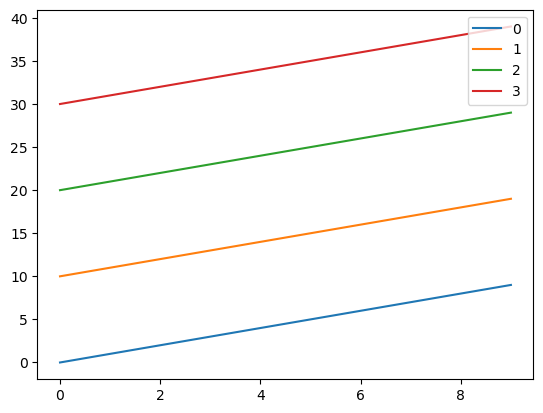

In [ ]:
for i, e in enumerate(b):
    plt.plot(e, label=i)
plt.legend()
plt.show()

In [ ]:
import os
os.mkdir("figs") if os.path.exists("figs") else 0

In [ ]:
a = {x:2*x for x in range(3)}

In [ ]:
list(a.keys())

[0, 1, 2]

In [ ]:
import torch
a = torch.tensor([0, 0, 1, 2]).to("cuda:3")

In [ ]:
num_dict = {x:0 for x in a.unique().cpu().numpy()}

In [ ]:
num_dict[0] = 3
num_dict[1] = 5
num_dict[2] = 8
for k, v in num_dict.items():
    print(k, v)

0 3
1 5
2 8


In [ ]:
num_dict

ba = [0, 0, 1, 2, 2]
for aa in a:
    print(aa.item())

0
0
1
2


In [ ]:
from torch.nn import functional as F
import torch

a = torch.tensor([[0.0, 1],
                  [2, 3]])


In [ ]:
np.reshape(np.arange(10), [2, 5])
np.arange(10).reshape([2, 5])

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [ ]:
import numpy as np
from torch.nn import functional as F
import torch

base = np.arange(12).reshape([4, 3])
new_grads = torch.tensor(base, dtype=float)
selected_idx = [1, 2]

In [ ]:
r_new_grads = new_grads[selected_idx]


In [ ]:
n_r_new_grads = F.normalize(r_new_grads, p=2, dim=1)

In [ ]:
n_r_new_grads

tensor([[0.4243, 0.5657, 0.7071],
        [0.4915, 0.5735, 0.6554]], dtype=torch.float64)

In [ ]:
selected_idx = [0, 1]
n_r_new_grads

tensor([[0.4243, 0.5657, 0.7071],
        [0.4915, 0.5735, 0.6554]], dtype=torch.float64)

In [ ]:
import numpy as np
import pandas as pd
from docplex.mp.model import Model

model = Model('Sample')

n = 4 # number of classes
m = 1200 # number of training samples

# A = np.ones([n, m])
A = np.random.random([n, m])
x_dict = (i for i in range(m))
b = np.random.random([n])
# b = np.ones([n])

x = model.binary_var_dict(x_dict, name = 'x', lb = 0, ub = 1)
obj = sum((sum(A[i,j]*x[j] for j in range(m)) - b[i])**2 for i in range(n))
model.set_objective("min", obj)

# model.solve(log_output=True)    # model object를 위에서 정의한 제약식과 목적함수를 이용해서 푸는 코드(log_output은 solver가 문제를 풀때, 진행 상태를 보여주는 것을 의미
model.solve(log_output=False)    # model object를 위에서 정의한 제약식과 목적함수를 이용해서 푸는 코드(log_output은 solver가 문제를 풀때, 진행 상태를 보여주는 것을 의미
print(model.solve_details)   # 문제가 풀렸을때 그 해에 대한 detail한 정보를 출력
# print(model.export_as_lp_string()) # 추가한 제약식 및 목적함수를 LP형태로 출력
print(model.solution)  # 문제의 solution을 출력
print("Solution status : " , model.get_solve_status())   # 찾은 해가 optimal, feasible, infeasible인지 출력
print("Objective value : " , model.objective_value )    # 목적함수값 출력
soln = model.solution.get_value_dict({f"x_{i}":x[i] for i in range(m)})
soln

status  = integer optimal solution
time    = 19661.6 s.
problem = MIQP
gap     = 0%

solution for: Sample
objective: 0.00229369
status: OPTIMAL_SOLUTION(2)
x_274=1
x_971=1

Solution status :  JobSolveStatus.OPTIMAL_SOLUTION
Objective value :  0.0022936940555138285


In [104]:
def LS_solver(A: np.array, b: np.array, binary = False):
    """
    Solve Least Square problem below
    min_x (Ax - b)**2 
    where
    x: [..., x_i, ...] (1-d array size m)
    0 ≤ x_i ≤ 1.
    Usually, n is number of class and m is number of training set.
    If binary is True, x_i is 0 or 1. 

    Args:
        A: given 2-d array size n ⨯ m
        b: given 1-d array size n
        binary: indicates the type of problem

    Return:
        x: np.array of solution
    """
    if A.shape[0] != b.shape[0]:
        raise NotImplementedError
    
    n, m = A.shape
    model = Model('Sample')
    x_dict = (i for i in range(m))
    if binary:
        x = model.binary_var_dict(x_dict, name = 'x', lb = 0, ub = 1)
    else:
        x = model.continuous_var_dict(x_dict, name = 'x', lb = 0, ub = 1)

    obj = sum((sum(A[i,j]*x[j] for j in range(m)) - b[i])**2 for i in range(n))
    model.set_objective("min", obj)

    model.solve(log_output=False)
    soln = np.array([x[i].solution_value for i in range(m)])
    return soln



In [20]:
len(soln)

120

In [21]:
a = np.arange(12).reshape(3, 4)
a[:,1]

array([1, 5, 9])

In [94]:
def minimax_LP_solver(*args, **kwargs):
    return minimax_LP_solver_v2(*args, **kwargs)


def minimax_LP_solver_v2(A: np.ndarray, b: np.ndarray, binary = False):
    """
    Solve Least Square problem below
    min_x max_i |A_i·x - b_i|
    where
    A_i : ith row vector of A (1-d array size m)
    b_i : ith element of b (scalar)
    x : [..., x_i, ...] (1-d array size m)
    0 ≤ x_i ≤ 1.
    Usually, n is number of class and m is number of training set.
    If binary is True, x_i is 0 or 1. 

    Args:
        A: given 2-d array size n ⨯ m
        b: given 1-d array size n
        binary: indicates the type of problem

    Return:
        x: np.array of solution
    """
    if A.shape[0] != b.shape[0]:
        raise NotImplementedError
    
    n, m = A.shape
    model = Model('minimax_LP')
    x_dict = (i for i in range(m))

    if binary:
        x = model.binary_var_dict(x_dict, name = 'x', lb = 0, ub = 1)
    else:
        x = model.continuous_var_dict(x_dict, name = 'x', lb = 0, ub = 1)
    y = model.continuous_var(name = 'y', lb = 0)

    c1 = model.add_constraints([-y + sum(A[i,j]*x[j] for j in range(m)) <=   b[i] for i in range(n)], names = "ub_")
    c2 = model.add_constraints([-y - sum(A[i,j]*x[j] for j in range(m)) <= - b[i] for i in range(n)], names = "lb_")

    model.set_objective("min", y)
    # model.print_information()
    # print(model.export_as_lp_string())
    model.solve(log_output=False) 
    soln = [x[i].solution_value for i in range(m)]
    # print("Objective value : " , model.objective_value )    # 목적함수값 출력
    return soln

In [107]:
import numpy as np

n = 4
m = 12000
A = np.arange(-100, n*m-100).reshape(n, m)
b = np.arange(-100, n-100)
out = LS_solver(A, b, binary = False)

In [101]:
import numpy as np

n = 4
m = 12000
A = np.arange(-100, n*m-100).reshape(n, m)
b = np.arange(-100, n-100)
out = minimax_LP_solver(A, b, binary = False)

In [41]:
print(model.solution)

solution for: Sample
objective: 0.00891581
status: OPTIMAL_SOLUTION(2)
x_0=0.000
x_1=0.000
x_2=0.000
x_3=0.000
x_4=0.000
x_5=0.000
x_6=0.000
x_7=0.000
x_8=0.000
x_9=0.000
x_10=0.000
x_11=0.000
x_12=0.000
x_13=0.000
x_14=0.000
x_15=0.000
x_16=0.000
x_17=0.000
x_18=0.000
x_19=0.000
x_20=0.000
x_21=0.000
x_22=0.000
x_23=0.000
x_24=0.000
x_25=0.000
x_26=0.000
x_27=0.000
x_28=0.000
x_29=0.000
x_30=0.000
x_31=0.748
x_32=0.000
x_33=0.000
x_34=0.000
x_35=0.000
x_36=0.000
x_37=0.000
x_38=0.000
x_39=0.000
x_40=0.000
x_41=0.000
x_42=0.000
x_43=0.000
x_44=0.000
x_45=0.000
x_46=0.000
x_47=0.000
x_48=0.000
x_49=0.000
x_50=0.000
x_51=0.000
x_52=0.000
x_53=0.000
x_54=0.000
x_55=0.000
x_56=0.000
x_57=0.000
x_58=0.000
x_59=0.000
x_60=0.000
x_61=0.000
x_62=0.000
x_63=0.000
x_64=0.000
x_65=0.000
x_66=0.000
x_67=0.000
x_68=0.000
x_69=0.000
x_70=0.000
x_71=0.000
x_72=0.000
x_73=0.000
x_74=0.000
x_75=0.000
x_76=0.000
x_77=0.000
x_78=0.000
x_79=0.000
x_80=0.000
x_81=0.000
x_82=0.000
x_83=0.000
x_84=0.000
x_85

In [ ]:
import cplex

def problem_setup(label, w_sim, edge, ILP):
    """         
        Constructs the label flipping optimization problem.
        If ILP is True, it constructs the ILP problem, otherwise constructs the LP problem.

        Args: 
            label: Labels of the data
            w_sim: Similarity matrix
            edge: Indices of similar pairs
            ILP: Indicates the type of problem
            
        Return:
            prob: Optimization problem
            x_idx: Index of the solution
    """

    m = 0
    prob = cplex.Cplex()
    prob.set_log_stream(None)
    prob.set_error_stream(None)
    prob.set_warning_stream(None)
    prob.set_results_stream(None)
    prob.objective.set_sense(prob.objective.sense.minimize)

    name_z = []
    name_x = []
    for i in range(label.shape[0]):
        name_z.append(f'z_{i}')
        name_x.append(f'x_{i}')
        
    prob.variables.add(names=name_z,obj = [1.0] * label.shape[0],types = [prob.variables.type.continuous] * label.shape[0], lb=[0.0] * label.shape[0], ub=[1.0]* label.shape[0])
    
    if ILP:
        x_idx = prob.variables.add(names=name_x,types = [prob.variables.type.binary] * label.shape[0], lb=[0] * label.shape[0], ub=[1]* label.shape[0])
    else:
        x_idx = prob.variables.add(names=name_x,types = [prob.variables.type.continuous] * label.shape[0], lb=[0] * label.shape[0], ub=[1]* label.shape[0])

    for i in range(label.shape[0]):
        prob.linear_constraints.add(
            lin_expr = [cplex.SparsePair(ind = [f"x_{i}", f"z_{i}"], val = [-1.0, 1.0]),
                        cplex.SparsePair(ind = [f"x_{i}", f"z_{i}"], val = [-1.0, 1.0]),
                        cplex.SparsePair(ind = [f"x_{i}", f"z_{i}"], val = [1.0, 1.0]),
                        cplex.SparsePair(ind = [f"x_{i}", f"z_{i}"], val = [1.0, 1.0])],
            senses = ["L", "G", "G", "L"],
            rhs = [label[i], -label[i], label[i], 2-label[i]],
            names = [f'c_{i}0',f'c_{i}1',f'c_{i}2',f'c_{i}3'])

    prob.linear_constraints.add(names=['violation'], senses=["L"], rhs=[m])
    for (i, j) in edge:
        prob.variables.add(names=[f'z_{i}{j}'], types = [prob.variables.type.continuous],lb=[0], ub=[1])
        prob.linear_constraints.set_linear_components('violation', [[f"z_{i}{j}"], [w_sim[i][j]]])
        prob.linear_constraints.add(
            lin_expr = [cplex.SparsePair(ind = [f"x_{i}", f"x_{j}",f"z_{i}{j}"], val = [-1.0, -1.0, 1.0]),
                        cplex.SparsePair(ind = [f"x_{i}", f"x_{j}",f"z_{i}{j}"], val = [-1.0, 1.0, 1.0]),
                        cplex.SparsePair(ind = [f"x_{i}", f"x_{j}",f"z_{i}{j}"], val = [1.0, -1.0, 1.0]),
                        cplex.SparsePair(ind = [f"x_{i}", f"x_{j}",f"z_{i}{j}"], val = [1.0, 1.0, 1.0])],
            senses = ["L", "G", "G", "L"],
            rhs = [0, 0, 0, 2],
            names = [f'c_{i}{j}0',f'c_{i}{j}1',f'c_{i}{j}2',f'c_{i}{j}3'])

    return prob, x_idx

def CPLEX_Solver(label, m, w_sim, edge, ILP = True):
    """         
        Solves the label flipping optimization problem for a given total error limit m using CPLEX.
        If ILP is True, it solves the ILP problem, otherwise solves the LP problem.

        Args: 
            label: Labels of the data
            m: The total error limit
            w_sim: Similarity matrix
            edge: Indices of similar pairs
            ILP: Indicates the type of problem
            
        Return:
            flipped_label: Flipped labels for a given m
    """

    prob, x_idx = problem_setup(label, w_sim, edge, ILP)
    
    # Set the total error limit m 
    # total_error_limit = get_error(prob)
    # prob.linear_constraints.set_rhs(total_error_limit, m)

    # Solve the problem
    prob.solve()
    sol = prob.solution

    return np.round(sol.get_values(list(x_idx)), decimals=4)

# def get_error(prob):
#     """ Finds the variables for m in the problem """

#     return get_name(prob, "violation")

# def get_name(prob, keyword):
#     """ Finds the variables for keyword in the problem """

#     changed_name = ""
#     for i in range(prob.linear_constraints.get_num()):
#         name = prob.linear_constraints.get_names(i)
#         if keyword in name:
#             changed_name = name
#             return changed_name

#     if changed_name == "":
#         print(f"Error: no {keyword}")
#         return